# 1) Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classification task. In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

## 1.1) Dataset

You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST(http://yann.lecun.com/exdb/mnist/) handwritten digit dataset. The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the load command. After loading, matrices of the correct dimensions and values will appear in your program's memory. The matrix will already be named, so you do not need to assign names to them.

```octave
% Load saved matrices from file
load('ex3data1.mat');
% The matrices X and y will now be in your Octave environment 
```

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

## 1.2) Visualizing the data

You will begin by visualizing a subset of the training set. In Part 1 of `ex3.m`, the code randomly selects selects 100 rows from `X` and passes those rows to the `displayData` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the `displayData` function, and you are encouraged to examine the code to see how it works. After you run this step, you should see an image like Figure 1.

In [2]:
function [h, display_array] = displayData(X, example_width)
    %DISPLAYDATA Display 2D data in a nice grid
    %   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
    %   stored in X in a nice grid. It returns the figure handle h and the 
    %   displayed array if requested.

    % Set example_width automatically if not passed in
    if ~exist('example_width', 'var') || isempty(example_width) 
        example_width = round(sqrt(size(X, 2)));
    end

    % Gray Image
    colormap(gray);

    % Compute rows, cols
    [m n] = size(X);
    example_height = (n / example_width);

    % Compute number of items to display
    display_rows = floor(sqrt(m));
    display_cols = ceil(m / display_rows);

    % Between images padding
    pad = 1;

    % Setup blank display
    display_array = - ones(pad + display_rows * (example_height + pad), ...
                           pad + display_cols * (example_width + pad));

    % Copy each example into a patch on the display array
    curr_ex = 1;
    for j = 1:display_rows
        for i = 1:display_cols
            if curr_ex > m, 
                break; 
            end
            % Copy the patch

            % Get the max value of the patch
            max_val = max(abs(X(curr_ex, :)));
            display_array(pad + (j - 1) * (example_height + pad) + (1:example_height), ...
                          pad + (i - 1) * (example_width + pad) + (1:example_width)) = ...
                            reshape(X(curr_ex, :), example_height, example_width) / max_val;
            curr_ex = curr_ex + 1;
        end
        if curr_ex > m, 
            break; 
        end
    end

    % Display Image
    h = imagesc(display_array, [-1 1]);

    % Do not show axis
    axis image off

    drawnow;

end


Loading and Visualizing Data ...


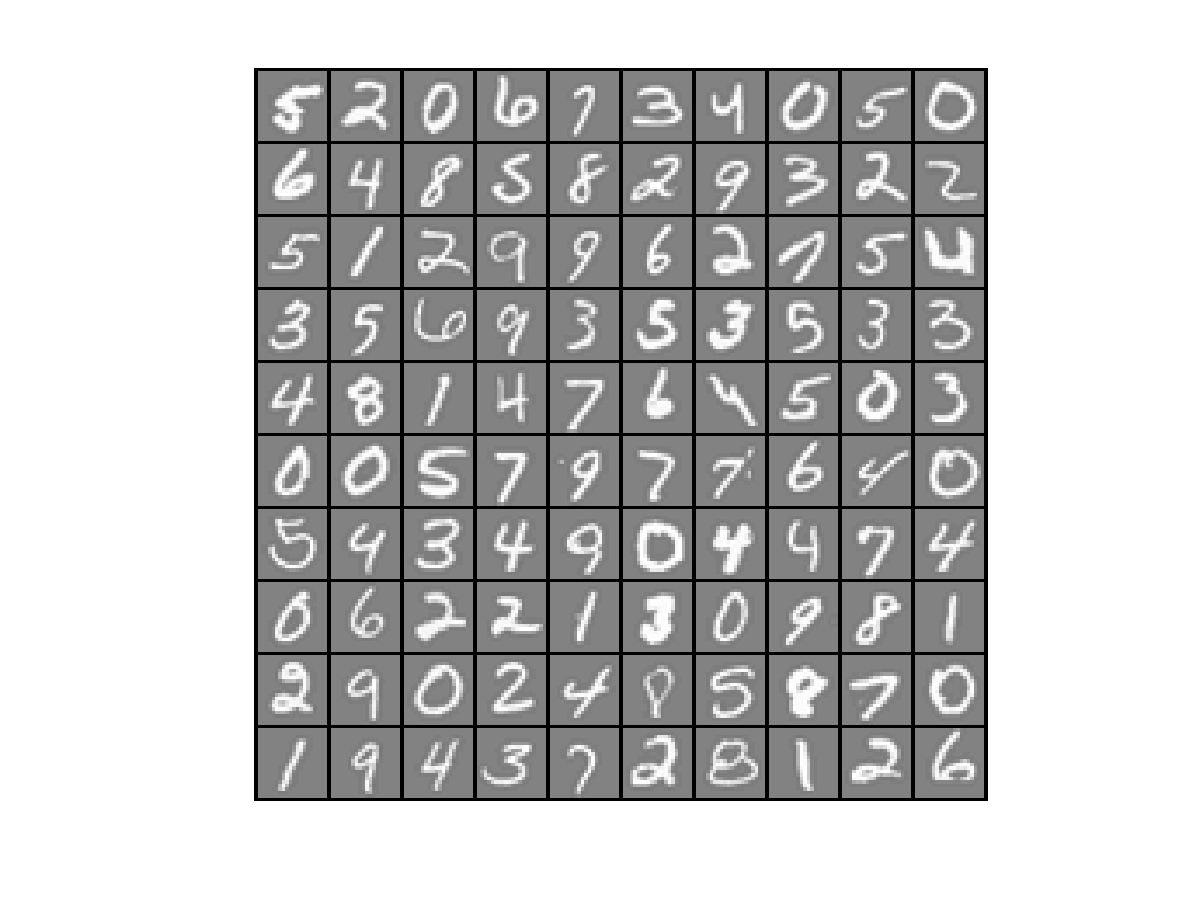

In [8]:
%% Initialization
clear ; close all; clc

%% Setup the parameters you will use for this part of the exercise
input_layer_size  = 400;  % 20x20 Input Images of Digits
num_labels = 10;          % 10 labels, from 1 to 10   
                          % (note that we have mapped "0" to label 10)

%% =========== Part 1: Loading and Visualizing Data =============
%  We start the exercise by first loading and visualizing the dataset. 
%  You will be working with a dataset that contains handwritten digits.

% Load Training Data
fprintf('Loading and Visualizing Data ...\n')

load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 4/Assignment/ex3/ex3data1.mat'); 
% training data stored in arrays X, y
m = size(X, 1);

% Randomly select 100 data points to display
rand_indices = randperm(m);
sel = X(rand_indices(1:100), :);

displayData(sel);


## 1.3) Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.

### 1.3.1 Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [-y^{(i)}log(h_\theta(x^{(i)})-(1 - y^{(i)})log(1 - h_\theta(x^{(i)}))]$$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^Tx^{(i)})$ and $g(z) = \frac{1}{1+e^{−z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define `X` and $\theta$ as

$$X = \begin{bmatrix}
- (x^{(1)})^T - \\ 
- (x^{(2)})^T - \\ 
- (x^{(3)})^T - \\ 
\vdots \\ 
- (x^{(m)})^T - \\
\end{bmatrix}, \ \ \ \ \text{and} \ \ \ \ 
\theta = \begin{bmatrix}
\theta_0 \\ 
\theta_1 \\ 
\theta_2 \\ 
\vdots \\ 
\theta_n \\
\end{bmatrix}$$

Then, by computing the matrix product `X`$\theta$, we have

$$X\theta = \begin{bmatrix}
- (x^{(1)})^T\theta - \\ 
- (x^{(2)})^T\theta - \\ 
- (x^{(3)})^T\theta - \\ 
\vdots \\ 
- (x^{(m)})^T\theta - \\
\end{bmatrix}$$

Thats equal to

$$X\theta = \begin{bmatrix}
- \theta^T(x^{(1)}) - \\ 
- \theta^T(x^{(2)}) - \\ 
- \theta^T(x^{(3)}) - \\ 
\vdots \\ 
- \theta^T(x^{(m)}) - \\
\end{bmatrix}$$

In the last equality, we used the fact that $a^Tb$ = $b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^Tx^{(i)}$ for all our examples $i$ in one line of code. Your job is to write the unregularized cost function in the file `lrCostFunction.m` Your implementation should use the strategy we presented above to calculate $\theta^Tx^{(i)}$ . You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction.m` should not contain any loops.

(Hint: You might want to use the element-wise multiplication operation (.*) and the sum operation sum when writing this function)

In [11]:
function g = sigmoid(z)
    %SIGMOID Compute sigmoid function
    %   J = SIGMOID(z) computes the sigmoid of z.

    % You need to return the following variables correctly 
    g = zeros(size(z));
    g = 1./(1.+exp(-1.*z));
end

### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is  vector where the j th element is defined as

$$\frac{\partial}{\partial\theta_0}J(\theta) = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)} - y^{(i)})x_j^{(i)}$$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$

$$\begin{bmatrix}
\frac{\partial J}{\partial\theta_0}\\ 
\frac{\partial J}{\partial\theta_1}\\ 
\frac{\partial J}{\partial\theta_2}\\ 
\vdots \\ 
\frac{\partial J}{\partial\theta_n}\\ 
\end{bmatrix} = \frac{1}{m}\begin{bmatrix}
\sum_{i=1}^{m}((h_\theta(x^{(i)})-y^{(i)})x_0^{(i)})\\
\sum_{i=1}^{m}((h_\theta(x^{(i)})-y^{(i)})x_1^{(i)})\\
\sum_{i=1}^{m}((h_\theta(x^{(i)})-y^{(i)})x_2^{(i)})\\
\vdots \\
\sum_{i=1}^{m}((h_\theta(x^{(i)})-y^{(i)})x_n^{(i)})\\
\end{bmatrix} = \frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x^{(i)}) = \frac{1}{m}X^T(h_\theta(x)-y)$$

where:

$$h_\theta(x) - y = \begin{bmatrix}
h_\theta(x^{(1)}) - y^{(1)}\\ 
h_\theta(x^{(2)}) - y^{(2)}\\ 
\vdots \\
h_\theta(x^{(m)}) - y^{(m)}
\end{bmatrix}$$

Note that $x^{(i)}$ is a vector, while $(h_\theta(x^{(i)}) - y^{(i)})$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = (h_\theta(x^{(i)}) - y^{(i)})$ and observe that:

$$\sum_i \beta_ix^{(i)} = \begin{bmatrix}
| & | &  & |\\
x^{(1)} & x^{(2)} & \dots & x^{(m)} \\
| & | &  & |\\
\end{bmatrix}\begin{bmatrix}
\beta_1\\
\beta_2\\
\vdots \\
\beta_m\\
\end{bmatrix} = X^T\beta$$

where the values $\beta_i = (h_\theta(x^{(i)}) - y^{(i)})$

The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. You should now implement Equation 1 to compute the correct vectorized gradient. Once you are done, complete the function `lrCostFunction.m` by implementing the gradient.

**Debugging Tip**: Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the size function. For example, given a data matrix `X` of size 100 × 20 (100 examples, 20 features) and $\theta$, a vector with dimensions 20 × 1, you can observe that `X`$\theta$ is a valid multiplication operation, while $\theta$`X` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.

### 1.3.3 Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [-y^{(i)}log(h_\Theta(x^{(i)})-(1 - y^{(i)})log(1 - h_\Theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$$

Note that you should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$\frac{\partial}{\partial\theta_0}J(\theta) = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$$

for j = 0, and 

$$\frac{\partial}{\partial\theta_j}J(\theta) = \left (\frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\right ) + \frac{\lambda}{m} \theta_j$$
 
for j >= 1. Now modify your code in `lrCostFunction` to account for regularization. Once again, you should not put any loops into your code.

**Octave/MATLAB Tip**: When implementing the vectorization for regularized logistic regression, you might often want to only sum and update certain elements of $\theta$. In Octave/MATLAB, you can index into the matrices to access and update only certain elements. For example, `A(:, 3:5) = B(:, 1:3)` will replaces the columns 3 to 5 of A with the columns 1 to 3 from B. One special keyword you can use in indexing is the end keyword in indexing. This allows us to select columns (or rows) until the end of the matrix. For example, `A(:, 2:end)` will only return elements from the 2nd to last column of `A`. Thus, you could use this together with the sum and `.^` operations to compute the sum of only the elements you are interested in (e.g., `sum(z(2:end).^2)`). In the starter code, `lrCostFunction.m`, we have also provided hints on yet another possible method computing the regularized gradient.

In [13]:
function [J, grad] = lrCostFunction(theta, X, y, lambda)
    %LRCOSTFUNCTION Compute cost and gradient for logistic regression with 
    %regularization
    %   J = LRCOSTFUNCTION(theta, X, y, lambda) computes the cost of using
    %   theta as the parameter for regularized logistic regression and the
    %   gradient of the cost w.r.t. to the parameters. 

    % Initialize some useful values
    m = length(y); % number of training examples

    % You need to return the following variables correctly 
    J = 0;
    grad = zeros(size(theta));

    % ====================== YOUR CODE HERE ======================
    % Instructions: Compute the cost of a particular choice of theta.
    %               You should set J to the cost.
    %               Compute the partial derivatives and set grad to the partial
    %               derivatives of the cost w.r.t. each parameter in theta
    %
    % Hint: The computation of the cost function and gradients can be
    %       efficiently vectorized. For example, consider the computation
    %
    %           sigmoid(X * theta)
    %
    %       Each row of the resulting matrix will contain the value of the
    %       prediction for that example. You can make use of this to vectorize
    %       the cost function and gradient computations. 
    %
    % Hint: When computing the gradient of the regularized cost function, 
    %       there're many possible vectorized solutions, but one solution
    %       looks like:
    %           grad = (unregularized gradient for logistic regression)
    %           temp = theta; 
    %           temp(1) = 0;   % because we don't add anything for j = 0  
    %           grad = grad + YOUR_CODE_HERE (using the temp variable)
    %

    h_theta = sigmoid(X*theta);
    theta1 = [0 ; theta(2:size(theta), :)];
    reg = (lambda/(2*m)) * theta1'*theta1;
    J = (1/m * ((-y)'*log(h_theta)-(1-y)'*log(1-h_theta))) +  reg;

    gradreg = (lambda/m)*theta1;
    grad = ((X'*(h_theta - y))/m)+gradreg;

    grad = grad(:);

end

## 1.4) One-vs-all Classification

In this part of the exercise, you will implement `one-vs-all` classification by training multiple regularized logistic regression classifiers, one for each of the `K` classes in our dataset (Figure 1). In the handwritten digits dataset, `K = 10`, but your code should work for any value of `K`.

You should now complete the code in `oneVsAll.m` to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{K×(N+1)}$ , where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a "for"-loop from 1 to `K`, training each classifier independently. Note that the `y` argument to this function is a vector of labels from 1 to 10, where we have mapped the digit "0" to the label 10 (to avoid confusions with indexing).

When training the classifier for class $k \in \{1, ..., K\}$, you will want a m-dimensional vector of labels `y`, where $y_j \in 0, 1$ indicates whether the j-th training instance belongs to class $k (y_j = 1)$, or if it belongs to a different class $(y_j = 0)$. You may find logical arrays helpful for this task.

**Octave/MATLAB Tip**: Logical arrays in Octave/MATLAB are arrays which contain binary (0 or 1) elements. In Octave/MATLAB, evaluating the expression `a == b` for a vector a (of size mx1) and scalar `b` will return a vector of the same size as a with ones at positions where the elements of `a` are equal to `b` and zeroes where they are different. To see how this works for yourself, try the following code in Octave/MATLAB:

```octave
a = 1:10; % Create a and b
b = 3;
a == b
% You should try different values of b here 
```
Furthermore, you will be using fmincg for this exercise (instead of `fminunc`). `fmincg` works similarly to `fminunc`, but is more more efficient for dealing with a large number of parameters.

After you have correctly completed the code for `oneVsAll.m`, the script `ex3.m` will continue to use your `oneVsAll` function to train a multi-class classifier.

In [14]:
a = 1:10;
b = 3;
a == b

ans =

   0   0   1   0   0   0   0   0   0   0



In [27]:
function [X, fX, i] = fmincg(f, X, options, P1, P2, P3, P4, P5)
    % Minimize a continuous differentialble multivariate function. Starting point
    % is given by "X" (D by 1), and the function named in the string "f", must
    % return a function value and a vector of partial derivatives. The Polack-
    % Ribiere flavour of conjugate gradients is used to compute search directions,
    % and a line search using quadratic and cubic polynomial approximations and the
    % Wolfe-Powell stopping criteria is used together with the slope ratio method
    % for guessing initial step sizes. Additionally a bunch of checks are made to
    % make sure that exploration is taking place and that extrapolation will not
    % be unboundedly large. The "length" gives the length of the run: if it is
    % positive, it gives the maximum number of line searches, if negative its
    % absolute gives the maximum allowed number of function evaluations. You can
    % (optionally) give "length" a second component, which will indicate the
    % reduction in function value to be expected in the first line-search (defaults
    % to 1.0). The function returns when either its length is up, or if no further
    % progress can be made (ie, we are at a minimum, or so close that due to
    % numerical problems, we cannot get any closer). If the function terminates
    % within a few iterations, it could be an indication that the function value
    % and derivatives are not consistent (ie, there may be a bug in the
    % implementation of your "f" function). The function returns the found
    % solution "X", a vector of function values "fX" indicating the progress made
    % and "i" the number of iterations (line searches or function evaluations,
    % depending on the sign of "length") used.
    %
    % Usage: [X, fX, i] = fmincg(f, X, options, P1, P2, P3, P4, P5)
    %
    % See also: checkgrad 
    %
    % Copyright (C) 2001 and 2002 by Carl Edward Rasmussen. Date 2002-02-13
    %
    %
    % (C) Copyright 1999, 2000 & 2001, Carl Edward Rasmussen
    % 
    % Permission is granted for anyone to copy, use, or modify these
    % programs and accompanying documents for purposes of research or
    % education, provided this copyright notice is retained, and note is
    % made of any changes that have been made.
    % 
    % These programs and documents are distributed without any warranty,
    % express or implied.  As the programs were written for research
    % purposes only, they have not been tested to the degree that would be
    % advisable in any important application.  All use of these programs is
    % entirely at the user's own risk.
    %
    % [ml-class] Changes Made:
    % 1) Function name and argument specifications
    % 2) Output display
    %

    % Read options
    if exist('options', 'var') && ~isempty(options) && isfield(options, 'MaxIter')
        length = options.MaxIter;
    else
        length = 100;
    end


    RHO = 0.01;                            % a bunch of constants for line searches
    SIG = 0.5;       % RHO and SIG are the constants in the Wolfe-Powell conditions
    INT = 0.1;    % don't reevaluate within 0.1 of the limit of the current bracket
    EXT = 3.0;                    % extrapolate maximum 3 times the current bracket
    MAX = 20;                         % max 20 function evaluations per line search
    RATIO = 100;                                      % maximum allowed slope ratio

    argstr = ['feval(f, X'];                 % compose string used to call function
    for i = 1:(nargin - 3)
        argstr = [argstr, ',P', int2str(i)];
    end
    argstr = [argstr, ')'];

    if max(size(length)) == 2, red=length(2); length=length(1); else red=1; end
    S=['Iteration '];

    i = 0;                                            % zero the run length counter
    ls_failed = 0;                             % no previous line search has failed
    fX = [];
    [f1 df1] = eval(argstr);                      % get function value and gradient
    i = i + (length<0);                                            % count epochs?!
    s = -df1;                                        % search direction is steepest
    d1 = -s'*s;                                                 % this is the slope
    z1 = red/(1-d1);                                  % initial step is red/(|s|+1)

    while i < abs(length)                                      % while not finished
        i = i + (length>0);                                    % count iterations?!

        X0 = X; f0 = f1; df0 = df1;                  % make a copy of current values
        X = X + z1*s;                                            % begin line search
        [f2 df2] = eval(argstr);
        i = i + (length<0);                                         % count epochs?!
        d2 = df2'*s;
        f3 = f1; d3 = d1; z3 = -z1;            % initialize point 3 equal to point 1
        if length>0, M = MAX; else M = min(MAX, -length-i); end
        success = 0; limit = -1;                             % initialize quanteties
        while 1
            while ((f2 > f1+z1*RHO*d1) || (d2 > -SIG*d1)) && (M > 0) 
                limit = z1;                                    % tighten the bracket
                if f2 > f1
                    z2 = z3 - (0.5*d3*z3*z3)/(d3*z3+f2-f3);          % quadratic fit
                else
                    A = 6*(f2-f3)/z3+3*(d2+d3);                          % cubic fit
                    B = 3*(f3-f2)-z3*(d3+2*d2);
                    z2 = (sqrt(B*B-A*d2*z3*z3)-B)/A;% numerical error possible - ok!
                end
                if isnan(z2) || isinf(z2)
                    z2 = z3/2;           % if we had a numerical problem then bisect
                end
                z2 = max(min(z2, INT*z3),(1-INT)*z3);% don't accept too close to limits
                z1 = z1 + z2;                                      % update the step
                X = X + z2*s;
                [f2 df2] = eval(argstr);
                M = M - 1; i = i + (length<0);                      % count epochs?!
                d2 = df2'*s;
                z3 = z3-z2;               % z3 is now relative to the location of z2
            end
            if f2 > f1+z1*RHO*d1 || d2 > -SIG*d1
                break;                                           % this is a failure
            elseif d2 > SIG*d1
                success = 1; break;                                        % success
            elseif M == 0
                break;                                                     % failure
            end
            A = 6*(f2-f3)/z3+3*(d2+d3);                   % make cubic extrapolation
            B = 3*(f3-f2)-z3*(d3+2*d2);
            z2 = -d2*z3*z3/(B+sqrt(B*B-A*d2*z3*z3));     % num. error possible - ok!
            if ~isreal(z2) || isnan(z2) || isinf(z2) || z2 < 0 % num prob or wrong sign?
                if limit < -0.5                          % if we have no upper limit
                    z2 = z1 * (EXT-1);          % the extrapolate the maximum amount
                else
                    z2 = (limit-z1)/2;                            % otherwise bisect
                end
            elseif (limit > -0.5) && (z2+z1 > limit)      % extraplation beyond max?
                z2 = (limit-z1)/2;                                          % bisect
            elseif (limit < -0.5) && (z2+z1 > z1*EXT)   % extrapolation beyond limit
                z2 = z1*(EXT-1.0);                      % set to extrapolation limit
            elseif z2 < -z3*INT
                z2 = -z3*INT;
            elseif (limit > -0.5) && (z2 < (limit-z1)*(1.0-INT))% too close to limit?
                z2 = (limit-z1)*(1.0-INT);
            end
            f3 = f2; d3 = d2; z3 = -z2;               % set point 3 equal to point 2
            z1 = z1 + z2; X = X + z2*s;                   % update current estimates
            [f2 df2] = eval(argstr);
            M = M - 1; i = i + (length<0);                          % count epochs?!
            d2 = df2'*s;
        end                                                     % end of line search
        if success                                        % if line search succeeded
            f1 = f2; fX = [fX' f1]';
            fprintf('%s %4i | Cost: %4.6e\r', S, i, f1);
            s = (df2'*df2-df1'*df2)/(df1'*df1)*s - df2;   % Polack-Ribiere direction
            tmp = df1; df1 = df2; df2 = tmp;                      % swap derivatives
            d2 = df1'*s;
            if d2 > 0                                   % new slope must be negative
                s = -df1;                         % otherwise use steepest direction
                d2 = -s'*s;    
            end
            z1 = z1 * min(RATIO, d1/(d2-realmin));       % slope ratio but max RATIO
            d1 = d2;
            ls_failed = 0;                           % this line search did not fail
        else
            X = X0; f1 = f0; df1 = df0;% restore point from before failed line search
            if ls_failed || i > abs(length)       % line search failed twice in a row
                break;                         % or we ran out of time, so we give up
            end
            tmp = df1; df1 = df2; df2 = tmp;                       % swap derivatives
            s = -df1;                                                  % try steepest
            d1 = -s'*s;
            z1 = 1/(1-d1);                    
            ls_failed = 1;                                  % this line search failed
        end
        if exist('OCTAVE_VERSION')
            fflush(stdout);
        end
    end
    fprintf('\n');
end

In [25]:
function [all_theta] = oneVsAll(X, y, num_labels, lambda)
    %ONEVSALL trains multiple logistic regression classifiers and returns all
    %the classifiers in a matrix all_theta, where the i-th row of all_theta 
    %corresponds to the classifier for label i
    %   [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
    %   logisitc regression classifiers and returns each of these classifiers
    %   in a matrix all_theta, where the i-th row of all_theta corresponds 
    %   to the classifier for label i

    % Some useful variables
    m = size(X, 1);
    n = size(X, 2);

    % You need to return the following variables correctly 
    all_theta = zeros(num_labels, n + 1);

    % Add ones to the X data matrix
    X = [ones(m, 1) X];

    % ====================== YOUR CODE HERE ======================
    % Instructions: You should complete the following code to train num_labels
    %               logistic regression classifiers with regularization
    %               parameter lambda. 
    %
    % Hint: theta(:) will return a column vector.
    %
    % Hint: You can use y == c to obtain a vector of 1's and 0's that tell use 
    %       whether the ground truth is true/false for this class.
    %
    % Note: For this assignment, we recommend using fmincg to optimize the cost
    %       function. It is okay to use a for-loop (for c = 1:num_labels) to
    %       loop over the different classes.
    %
    %       fmincg works similarly to fminunc, but is more efficient when we
    %       are dealing with large number of parameters.
    %
    % Example Code for fmincg:
    %
    %     % Set Initial theta
    %     initial_theta = zeros(n + 1, 1);
    %     
    %     % Set options for fminunc
    %     options = optimset('GradObj', 'on', 'MaxIter', 50);
    % 
    %     % Run fmincg to obtain the optimal theta
    %     % This function will return theta and the cost 
    %     [theta] = ...
    %         fmincg (@(t)(lrCostFunction(t, X, (y == c), lambda)), ...
    %                 initial_theta, options);
    %
    for i = 1:num_labels
      initial_theta = zeros(n+1, 1);
      options = optimset('GradObj', 'on', 'MaxIter', 50);
      [theta] = fmincg(@(t)(lrCostFunction(t, X, (y==i), lambda)), ...
                       initial_theta, options);
      all_theta(i, :) = theta';
    end
end

In [28]:
fprintf('\nTraining One-vs-All Logistic Regression...\n')

lambda = 0.1;
[all_theta] = oneVsAll(X, y, num_labels, lambda);


Training One-vs-All Logistic Regression...
Iteration    50 | Cost: 1.375845e-02
Iteration    50 | Cost: 5.725255e-02
Iteration    50 | Cost: 6.356910e-02
Iteration    50 | Cost: 3.692213e-02
Iteration    50 | Cost: 6.153066e-02
Iteration    50 | Cost: 2.172653e-02
Iteration    50 | Cost: 3.639718e-02
Iteration    50 | Cost: 8.466880e-02
Iteration    50 | Cost: 7.980136e-02
Iteration    50 | Cost: 9.775784e-03


### 1.4.1) One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the "probability" that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or `K`) as the prediction for the input example. You should now complete the code in `predictOneVsAll.m` to use the one-vs-all classifier to make predictions.

Once you are done, `ex3.m` will call your `predictOneVsAll` function using the learned value of $\theta$. You should see that the training set accuracy is about 94.9% (i.e., it classifies 94.9% of the examples in the training set correctly).

In [44]:
function p = predictOneVsAll(all_theta, X)
    %PREDICT Predict the label for a trained one-vs-all classifier. The labels 
    %are in the range 1..K, where K = size(all_theta, 1). 
    %  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
    %  for each example in the matrix X. Note that X contains the examples in
    %  rows. all_theta is a matrix where the i-th row is a trained logistic
    %  regression theta vector for the i-th class. You should set p to a vector
    %  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
    %  for 4 examples) 

    m = size(X, 1);
    num_labels = size(all_theta, 1);

    % You need to return the following variables correctly 
    p = zeros(size(X, 1), 1);

    % Add ones to the X data matrix
    X = [ones(m, 1) X];

    % ====================== YOUR CODE HERE ======================
    % Instructions: Complete the following code to make predictions using
    %               your learned logistic regression parameters (one-vs-all).
    %               You should set p to a vector of predictions (from 1 to
    %               num_labels).
    %
    % Hint: This code can be done all vectorized using the max function.
    %       In particular, the max function can also return the index of the 
    %       max element, for more information see 'help max'. If your examples 
    %       are in rows, then, you can use max(A, [], 2) to obtain the max 
    %       for each row.
    %       
    h = sigmoid(X*all_theta');
    [val, p] = max(h, [], 2);
end
%pred = predictOneVsAll(all_theta, X);

In [45]:
%% ================ Part 3: Predict for One-Vs-All ================
%  After ...
pred = predictOneVsAll(all_theta, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 95.060000


# 2 Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier (you could add more features (such as polynomial features) to logistic regression, but that can be very expensive to train).

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week's exercise, you will write the backpropagation algorithm for learning the neural network parameters.

The provided script, `ex3_nn.m`, will help you step through this exercise.

## 2.1) Model representation

Our neural network is shown in Figure 2. It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables `X` and `y`.

You have been provided with a set of network parameters ($\theta^{(1)}$ , $\theta^{(2)}$) already trained by us. These are stored in `ex3weights.mat` and will be loaded by `ex3_nn.m` into `Theta1` and `Theta2` The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

```octave
% Load saved matrices from file
load('ex3weights.mat');

%The matrices Theta1 and Theta2 will now be in your Octave
%environment
%Theta1 has size 25 x 401
%Theta2 has size 10 x 26
```
<img src="neuralnet.png", width="50%"/>

## 2.2 Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in `predict.m` to return the neural network's prediction. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example `i` and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $(h_\theta(x))_k$ .

**Implementation Note**: The matrix `X` contains the examples in rows. When you complete the code in `predict.m`, you will need to add the column of 1's to the matrix. The matrices `Theta1` and `Theta2` contain the parameters for each unit in rows. Specifically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. In Octave/MATLAB, when you compute $z^{(2)} = \theta^{(1)}a^{(1)}$, be sure that you index (and if necessary, transpose) `X` correctly so that you get a (`l`) as a column vector.

Once you are done, `ex3_nn.m` will call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%. After that, an interactive sequence will launch dis-
playing images from the training set one at a time, while the console prints out the predicted label for the displayed image. To stop the image sequence, press Ctrl-C.



Loading and Visualizing Data ...


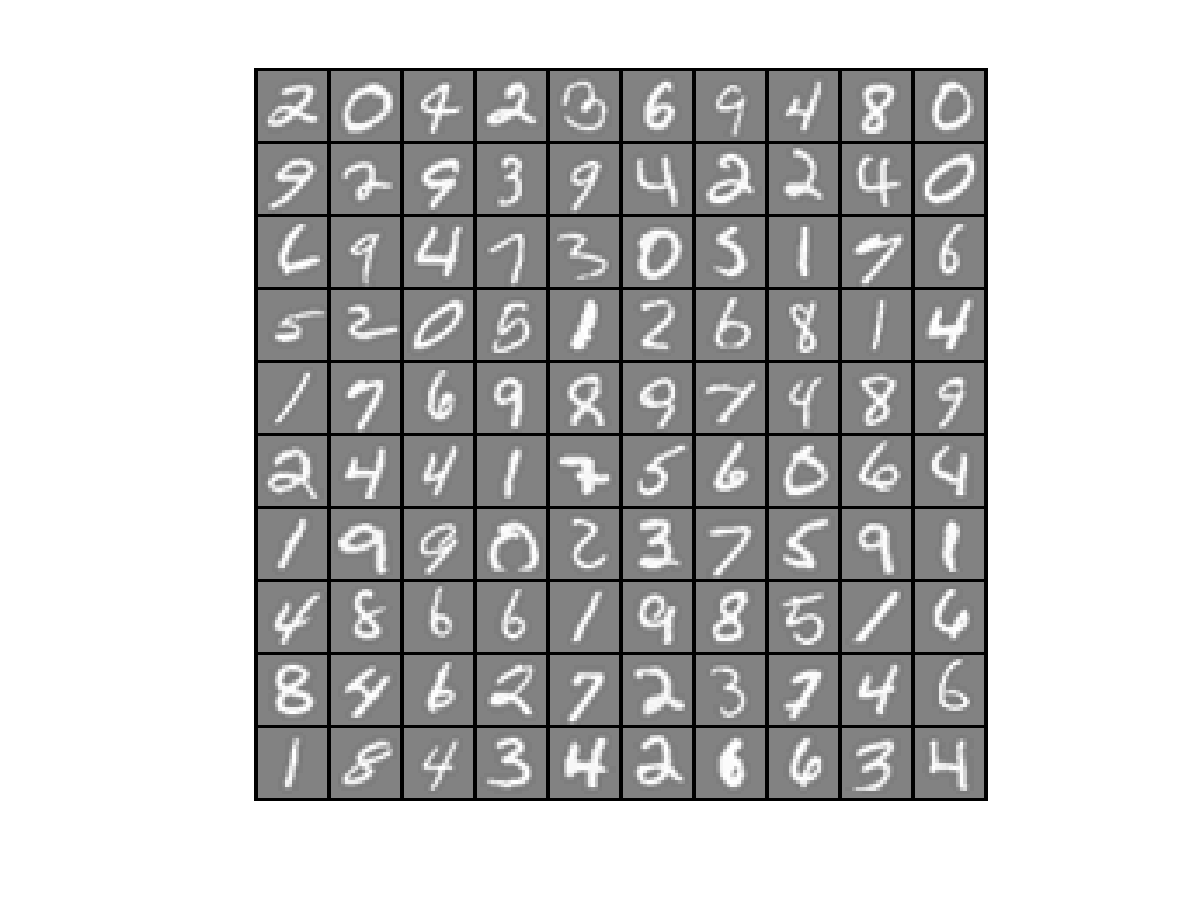

In [3]:
%% Initialization
clear ; close all; clc

%% Setup the parameters you will use for this exercise
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10   
                          % (note that we have mapped "0" to label 10)

%% =========== Part 1: Loading and Visualizing Data =============
%  We start the exercise by first loading and visualizing the dataset. 
%  You will be working with a dataset that contains handwritten digits.
%

% Load Training Data
fprintf('Loading and Visualizing Data ...\n')

load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 4/Assignment/ex3/ex3data1.mat');
m = size(X, 1);

% Randomly select 100 data points to display
sel = randperm(size(X, 1));
sel = sel(1:100);

displayData(X(sel, :));

In [5]:
%% ================ Part 2: Loading Pameters ================
% In this part of the exercise, we load some pre-initialized 
% neural network parameters.

fprintf('\nLoading Saved Neural Network Parameters ...\n')

% Load the weights into variables Theta1 and Theta2
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 4/Assignment/ex3/ex3weights.mat');


Loading Saved Neural Network Parameters ...


In [15]:
function p = predict(Theta1, Theta2, X)
    %PREDICT Predict the label of an input given a trained neural network
    %   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    %   trained weights of a neural network (Theta1, Theta2)

    % Useful values
    m = size(X, 1);
    num_labels = size(Theta2, 1);

    % You need to return the following variables correctly 
    p = zeros(size(X, 1), 1);

    % ====================== YOUR CODE HERE ======================
    % Instructions: Complete the following code to make predictions using
    %               your learned neural network. You should set p to a 
    %               vector containing labels between 1 to num_labels.
    %
    % Hint: The max function might come in useful. In particular, the max
    %       function can also return the index of the max element, for more
    %       information see 'help max'. If your examples are in rows, then, you
    %       can use max(A, [], 2) to obtain the max for each row.
    %
    % Add ones to the X data matrix
    X = [ones(m, 1) X];
    a2 = sigmoid(X*Theta1');
    a2 = [ones(m, 1) a2];
    a3 = sigmoid(a2*Theta2');
    [val, p] = max(a3, [], 2);
end

In [16]:
%% ================= Part 3: Implement Predict =================
%  After training the neural network, we would like to use it to predict
%  the labels. You will now implement the "predict" function to use the
%  neural network to predict the labels of the training set. This lets
%  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 97.520000
